# Plotting DVL and Slocum Glider Data with Pandas & Seaborn

---
## Import Libraries

In [642]:
import datetime
import earthpy as et
import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import seaborn as sns 
import struct
import sys
from PIL import Image
from matplotlib import pyplot as plt 

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
sns.set()

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)

---
## Load or Parse DVL data 

In [559]:
reload_modules()
filepath = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-raw/%s/" % (glider)
# filename = "01820002.pd0" # example of prime data set to work with
# filename = "01740000.pd0" # example of file not parsing correctly
# filename = "sk261222.pd0" # example of another cool mission (less bottom track, long dive)
filename = "sk261222.pd0"
ts = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename, save=False)

________________________________________
- Parsing New File ---------------------
    input file: /Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/pd0-raw/sentinel/sk261222.pd0
    # ensembles:    200
    # ensembles:    400
    # ensembles:    600
    # ensembles:    800
    # ensembles:   1000
    # ensembles:   1200
    # ensembles:   1400
    # ensembles:   1600
    # ensembles:   1800
    # ensembles:   2000
    # ensembles:   2200
    # ensembles:   2400
    # ensembles:   2600
- Parsing Complete ---------------------
    # ensembles:   2794
    parsing time:  22.305339
- Sensor Configuration -----------------
    600kHz System
    Convex Beam Pattern
    Sensor Config #1
    Attached
    Down Facing
    30E Beam Angle
    4 Beam Janus
- Coordinate Transformation ------------
    Bin Mapping Used
    3-Beam Soln Used
    Tilts Used
    Earth Coords


---
## Load or Parse Slocum Glider data 

In [674]:
reload_modules()
glider   = "sentinel"
filepath = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/Kolumbo cruise 2019/zduguid/dbd-parsed/%s/" % (glider)
filename = "sentinel-2019-329-3-0.asc"

ts_g = SlocumFlightController.SlocumFlightController.from_asc(filepath+filename, save=False)

________________________________________
- Parsing Slocum File (Flight) ---------
    input file: sentinel-2019-329-3-0.asc
    # ensembles:    200
    # ensembles:    400
    # ensembles:    600
    # ensembles:    800
    # ensembles:   1000
    # ensembles:   1200
    # ensembles:   1400
    # ensembles:   1600
    # ensembles:   1800
    # ensembles:   2000
    # ensembles:   2200
    # ensembles:   2400
- Parsing Complete ---------------------
    # ensembles:   2551
    parsing time:  1.241508


---
## Plotting

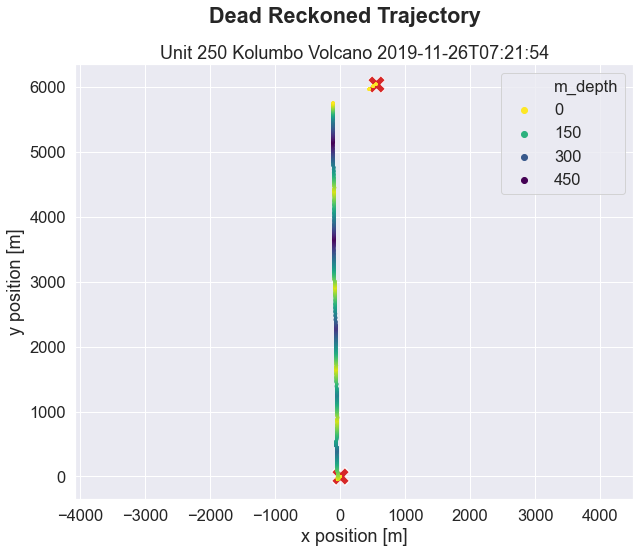

In [675]:
reload_modules()
glider = "sentinel"
dvl_plotter.plot_m_odometry_dr(ts_g, glider)